# Part 2: Fundamental Matrix Estimation, Camera Calibration, Triangulation

## Fundamental Matrix Estimation

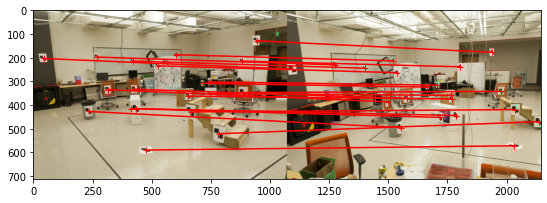

[[ 880.  214.  731.  238.]
 [  43.  203.   22.  248.]
 [ 270.  197.  204.  230.]
 [ 886.  347.  903.  342.]
 [ 745.  302.  635.  316.]
 [ 943.  128.  867.  177.]
 [ 476.  590.  958.  572.]
 [ 419.  214.  328.  244.]
 [ 317.  335.  426.  386.]
 [ 783.  521. 1064.  470.]
 [ 235.  427.  480.  495.]
 [ 665.  429.  964.  419.]
 [ 655.  362.  695.  374.]
 [ 427.  333.  505.  372.]
 [ 412.  415.  645.  452.]
 [ 746.  351.  692.  359.]
 [ 434.  415.  712.  444.]
 [ 525.  234.  465.  263.]
 [ 716.  308.  591.  324.]
 [ 602.  187.  447.  213.]]


In [117]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

##
## load images and match files for the first example
##

I1 = Image.open('MP3_part2_data/lab1.jpg');
I2 = Image.open('MP3_part2_data/lab2.jpg');
matches = np.loadtxt('MP3_part2_data/lab_matches.txt'); 

# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image: 
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image

N = len(matches)

##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##
I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(221)
ax.set_aspect('equal')
ax.imshow(np.array(I3).astype(int))
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
plt.show()
print(matches)

In [118]:
import numpy.linalg as la
means = np.mean(matches, axis=0)
matches_temp = matches - means
print(np.mean(matches_temp, axis=0))
norms_0 = np.mean(la.norm(matches_temp[:,:2], axis=1))
norms_1 = np.mean(la.norm(matches_temp[:,2:], axis=1))
print(norms_0, norms_1)
T0 = np.array([[2./norms_0, 0, -2 / norms_0 * means[0]], [0,2./norms_0, -2 / norms_0*means[1]], [0,0,1]])
T1 = np.array([[2./norms_1, 0, -2 / norms_1 * means[2]], [0,2./norms_1, -2 / norms_1*means[3]], [0,0,1]])
matches_0 = np.ones((matches.shape[0], 3))
matches_0[:,:2] = (matches[:,:2]).copy()

matches_0 = (T0 @ matches_0.T).T

matches_1 = np.ones((matches.shape[0], 3))
matches_1[:,:2] = (matches[:,2:]).copy()
matches_1 = (T1 @ matches_1.T).T

matches_normalized = np.zeros((matches.shape[0], 4))
matches_normalized[:,:2] = matches_0[:,:2]
matches_normalized[:,2:] = matches_1[:,:2]
print(np.mean(matches, axis=0))
print(np.mean(matches_normalized, axis=0))
def fit_fundamental(matches):
    x0 = matches[:,0].reshape(-1,1)
    y0 = matches[:,1].reshape(-1,1)
    x1 = matches[:,2].reshape(-1,1)
    y1 = matches[:,3].reshape(-1,1)
    X = np.concatenate((x1*x0, x1*y0, x1, y1*x0, y1*y0, y1, x0, y0, np.ones_like(x0)), axis=1)
    U, s, Vt = la.svd(X)
    f = Vt[-1,:]
    F = f.reshape(3,3)
    #
    U,s,Vt = la.svd(F)
    S = np.diag(s[:2])
    F = U[:,:2] @ S @ Vt[:2,:]
    return F

[-4.54747351e-14 -2.27373675e-14 -4.54747351e-14  2.27373675e-14]
238.34539440229656 234.3539823513933
[558.95 325.6  616.7  346.9 ]
[-4.44089210e-16 -2.77555756e-16 -7.54951657e-16  1.55431223e-16]


0.9064654437128721


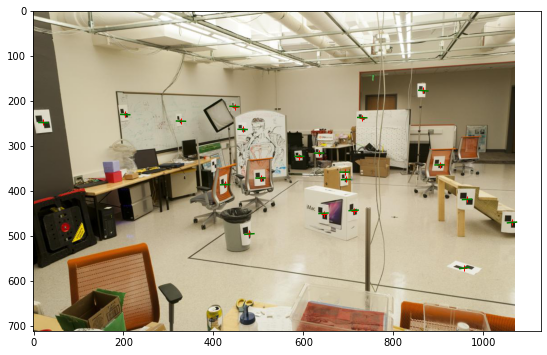

In [121]:
##
## display second image with epipolar lines reprojected 
## from the first image
##

# first, fit fundamental matrix to the matches
F = fit_fundamental(matches_normalized); # this is a function that you should write
F = T1.T @ F @ T0
M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
L1 = np.matmul(F, M).transpose() # transform points from 
# the first image to get epipolar lines in the second image
matches_0 = np.ones((matches.shape[0], 3))
matches_0[:,:2] = matches[:,:2]
matches_1 = np.ones((matches.shape[0], 3))
matches_1[:,:2] = matches[:,2:]
matches_projected = matches_1  @ F @ matches_0.T
print(np.mean(matches_projected**2))


# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

# find endpoints of segment on epipolar line (for display purposes)
pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

# display points and segments of corresponding epipolar lines
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(221)
ax.set_aspect('equal')
ax.imshow(np.array(I2).astype(int))
ax.plot(matches[:,2],matches[:,3],  '+r')
ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
plt.show()


## Camera Calibration

In [122]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

In [123]:
lab_matches = np.loadtxt('MP3_part2_data/lab_matches.txt')
sample_size = lab_matches.shape[0]
kp_pos3D = np.loadtxt('MP3_part2_data/lab_3d.txt')
kp_homo3D = np.concatenate((kp_pos3D, np.ones((sample_size, 1))), axis=1)
kp_pos0 = lab_matches[:,:2]
kp_pos1 = lab_matches[:,2:]

A = np.zeros((2 * sample_size, 12))
for j in range(sample_size):
    ind = j * 2
    A[ind,:4] = 0
    A[ind, 4:8] = kp_homo3D[j]
    A[ind, 8:] = -1 * kp_pos0[j,1] * kp_homo3D[j]

    ind = j * 2 + 1
    A[ind,:4] = kp_homo3D[j]
    A[ind, 4:8] = 0
    A[ind, 8:] = -1 * kp_pos0[j,0] * kp_homo3D[j]
U, s, Vt = la.svd(A)
p = Vt[-1]
P0 = p.reshape(3,4)

A = np.zeros((2 * sample_size, 12))
for j in range(sample_size):
    ind = j * 2
    A[ind,:4] = 0
    A[ind, 4:8] = kp_homo3D[j]
    A[ind, 8:] = -1 * kp_pos1[j,1] * kp_homo3D[j]

    ind = j * 2 + 1
    A[ind,:4] = kp_homo3D[j]
    A[ind, 4:8] = 0
    A[ind, 8:] = -1 * kp_pos1[j,0] * kp_homo3D[j]
U, s, Vt = la.svd(A)
p = Vt[-1]
P1 = p.reshape(3,4)

In [124]:
print(P0, P1)

[[-3.09963996e-03 -1.46204548e-04  4.48497465e-04  9.78930678e-01]
 [-3.07018252e-04 -6.37193664e-04  2.77356178e-03  2.04144405e-01]
 [-1.67933533e-06 -2.74767684e-06  6.83964827e-07  1.32882928e-03]] [[ 6.93154686e-03 -4.01684470e-03 -1.32602928e-03 -8.26700554e-01]
 [ 1.54768732e-03  1.02452760e-03 -7.27440714e-03 -5.62523256e-01]
 [ 7.60946050e-06  3.70953989e-06 -1.90203244e-06 -3.38807712e-03]]


In [6]:

points_proj0, residual0 = evaluate_points(P0, kp_pos0, kp_pos3D)
mse0 = np.sum((points_proj0 - kp_pos0)**2)/points_proj0.shape[0]
print("camera0: residual= ", residual0, " , mse= ", mse0)
points_proj1, residual1 = evaluate_points(P1, kp_pos1, kp_pos3D)
mse1 = np.sum((points_proj1 - kp_pos1)**2)/points_proj1.shape[0]
print("camera1: residual= ", residual1, " , mse= ", mse1)

camera0: residual=  13.545832894770703  , mse=  0.7861522862072994
camera1: residual=  15.544953451653466  , mse=  0.7456675076920228


## Camera Centers

In [171]:
P0 = np.loadtxt('MP3_part2_data/library1_camera.txt'); 
P1 = np.loadtxt('MP3_part2_data/library2_camera.txt'); 
camera_center0 = np.ones(4)
camera_center0[:3] = la.solve(P0[:,:3], -1 * P0[:,3])
camera_center1 = np.ones(4)
camera_center1[:3] = la.solve(P1[:,:3], -1 * P1[:,3])
print(camera_center0)

[  7.28863053 -21.52118112  17.73503585   1.        ]


## Triangulation

(309, 4)


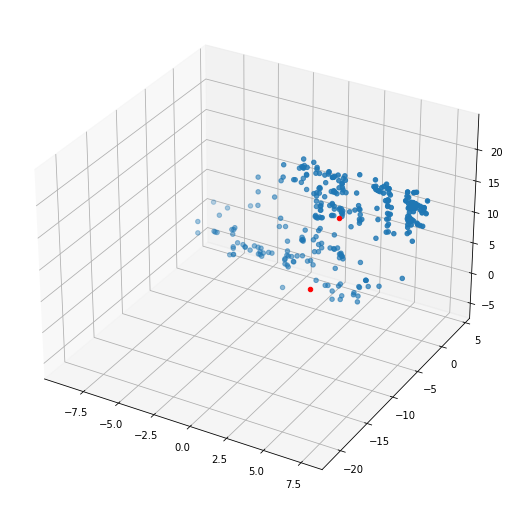

In [175]:
library_matches = np.loadtxt('MP3_part2_data/library_matches.txt')
kp_pos0 = library_matches[:,:2]
kp_pos1 = library_matches[:,2:]
kp_projected = np.ones((kp_pos0.shape[0], 4))
for i in range(kp_pos0.shape[0]):
    x0 = np.zeros((3 , 3))
    x0[0,:] = np.array([0,-1, kp_pos0[i, 1]])
    x0[1,:] = np.array([1,0, -1 * kp_pos0[i, 0]])
    x0[2,:] = np.array([-1 * kp_pos0[i, 1],kp_pos0[i, 0], 0])
    xp0 = x0 @ P0

    x1 = np.zeros((3 , 3))
    x1[0,:] = np.array([0,-1, kp_pos1[i, 1]])
    x1[1,:] = np.array([1,0, -1 * kp_pos1[i, 0]])
    x1[2,:] = np.array([-1 * kp_pos1[i, 1],kp_pos1[i, 0], 0])
    xp1 = x1 @ P1

    xp = np.concatenate((xp0, xp1), axis=0)

    U, s, Vt = la.svd(xp[:,:3], full_matrices=False)
    sinv = 1/s
    Sigma_inv = np.diag(sinv)

    X = -1 * Vt.T @ Sigma_inv @ U.T @ xp[:,3]
    kp_projected[i,:-1] = X

fig = plt.figure(figsize=(20,20))
ax = plt.subplot(221, projection='3d')
ax.scatter(kp_projected[:,0], kp_projected[:,1], kp_projected[:,2])
ax.scatter(camera_center0[0], camera_center0[1], camera_center0[2], c='r')
ax.scatter(camera_center1[0], camera_center1[1], camera_center1[2], c='r')
print(kp_projected.shape)
#plt.scatter([0,1.,2,0,1,2,0,1,2], [0,0,0,1,1,1,2,2,2], [5,5,5,5,5,5,5,5,5])
